In [1]:
import os
from os import path, listdir
from os.path import join, isfile
from glob import glob
from pathlib import Path
import cv2

import random
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import PIL.Image as Image
import matplotlib.pyplot as plt

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

covid_images_path = os.path.join("images", "COVID-19") 
normal_images_path = os.path.join("images", "Normal")
bacteria_images_path = os.path.join("images", "Bacteria")
virus_images_path = os.path.join("images", "Virus")

covid_images = [os.path.join(covid_images_path, f) for f in listdir(covid_images_path) if isfile(join(covid_images_path, f))]
normal_images = [os.path.join(normal_images_path, f) for f in listdir(normal_images_path) if isfile(join(normal_images_path, f))]
bacteria_images = [os.path.join(bacteria_images_path, f) for f in listdir(bacteria_images_path) if isfile(join(bacteria_images_path, f))]
virus_images = [os.path.join(virus_images_path, f) for f in listdir(virus_images_path) if isfile(join(virus_images_path, f))]

print(f"Total covid_images: {len(covid_images)}")
print(f"Total normal_images: {len(normal_images)}")
print(f"Total bacteria_images: {len(bacteria_images)}")
print(f"Total virus_images: {len(virus_images)}")

Total covid_images: 179
Total normal_images: 179
Total bacteria_images: 179
Total virus_images: 179


# Data exploration

We will be looking at COVID-19, Bacteria and Normal X-ray images. I have attempt to add in Virus X-ray images but the result was poor.

In [2]:
dataset = []    
for file in covid_images:    
    dataset.append([Path(covid_images[0]).parent.name, file])

for file in normal_images:    
    dataset.append([Path(normal_images[0]).parent.name, file])
    
for file in bacteria_images:    
    dataset.append([Path(bacteria_images[0]).parent.name, file])
    
# for file in virus_images:    
#     dataset.append([Path(virus_images[0]).parent.name, file])
    
pd.set_option('max_colwidth', 500)
df = pd.DataFrame(dataset)
df.columns = ['Class', 'Path']
total_labels = len(set(df['Class'].values))
labels = set(df['Class'].values)

print(f"Total number of labels: {total_labels}")
print(df.info())

df.sample(n=5)

Total number of labels: 3
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 537 entries, 0 to 536
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Class   537 non-null    object
 1   Path    537 non-null    object
dtypes: object(2)
memory usage: 8.5+ KB
None


,Class,Path
460,Bacteria,images\Bacteria\person334_bacteria_1544.jpeg
8,COVID-19,images\COVID-19\1-s2.0-S1684118220300608-main.pdf-002.jpg
138,COVID-19,images\COVID-19\gr1_lrg-b.jpg
341,Normal,images\Normal\NORMAL2-IM-1264-0001.jpeg
163,COVID-19,images\COVID-19\radiol.2020201160.fig2c.jpeg


## Viewing some samples

In [3]:
image_shape = (100, 100, 3)

def resize_image(img_array):
    img = Image.fromarray(img_array)
    img = img.resize(image_shape[:-1])
    return np.array(img)

def show_images(images, title=""):
    fig, ax = plt.subplots(1, len(images), figsize=(10, 10), dpi=100)   
    for i, img in enumerate(images):
        ax[i].imshow(img)
        ax[i].set_title(title)
    [x.axis('off') for x in ax]
    plt.show()
    
def load_images(image_paths):
    images = [np.array(Image.open(img).convert('RGB')) for img in image_paths]
    images = [resize_image(img) for img in images]    
    return np.array(images)

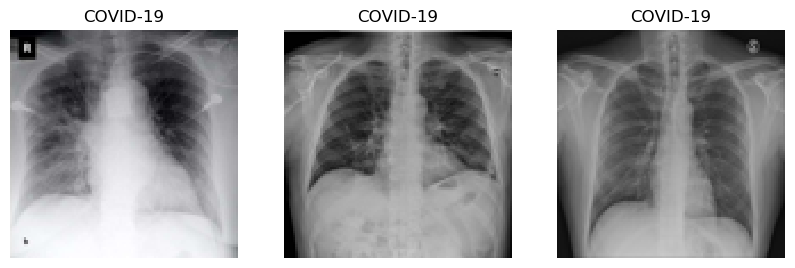

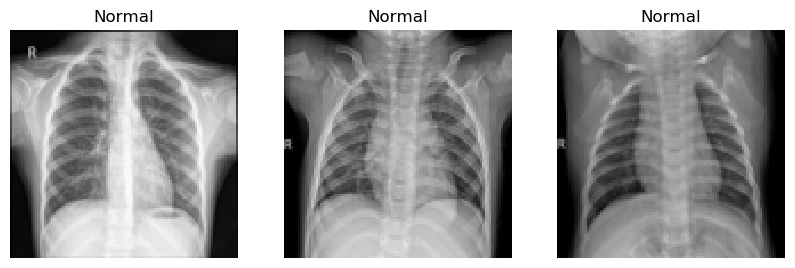

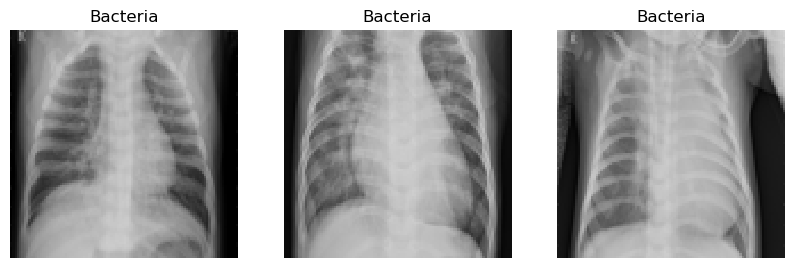

In [4]:
# View random 3 samples from each character label
for l in labels:
    char_imgs = df[df['Class']==l]['Path']
    char_imgs = load_images(char_imgs.values)        
    show_images(random.sample(list(char_imgs), 3), l)

# Train test split from dataset

We will select 10 images from each class and the rest of the images will be use as test set.

In [5]:
train_list = []
test_list = []

for l in labels:   
    char_imgs = df[df['Class']==l]
    
    print(l)
    df_train, df_test = train_test_split(char_imgs, test_size=0.94, random_state=42)
    
    train_list.append(df_train)
    test_list.append(df_test)
    
df_X_train = pd.concat(train_list)   
df_X_test = pd.concat(test_list)

COVID-19
Normal
Bacteria


## Verifying split results

In [6]:
# Train samples
df_X_train.groupby('Class').count()

,Path
Class,
Bacteria,10
COVID-19,10
Normal,10


In [7]:
# Test samples
df_X_test.groupby('Class').count()

,Path
Class,
Bacteria,169
COVID-19,169
Normal,169


# Creating generator

__Data Generator__

For DataGenerator in training and validation.

We randomly select from each classes but we have to make sure different and same set are balanced.

Notice that we did not use augmentation for this case.
<br><br>

__N-way validation__

For scoring our model, we will be using N-way validation.

Anchor class must be the same and there is only 1 correct class in the entire N set. Then select the maximum predicted score from this set to see if model is able to identify the correct pair. Repeat this X numbers of time to determine it's overall score.

Where different pair = 0, similar pair = 1.

When N = 5

| Char1         | Char2          | Label  |
| ------------- | -------------- |:------:|
| A             | B              | 0      |
| A             | A1             | 1      |
| A             | C              | 0      |
| A             | D              | 0      |
| A             | E              | 0      |


In [8]:
class Data_Generator(object):
    
    def __init__(self, df, image_shape, batch_size):
        # Prepare parameters
        self.df = df.copy()
        self.h, self.w, self.c = image_shape
        self.batch_size = batch_size
        self.labels = list(set(self.df['Class']))
    
    def resize_image(self, img_array):
        img = Image.fromarray(img_array)
        img = img.resize(image_shape[:-1])
        return np.array(img)
    
    def load_image(self, url):
        img = Image.open(url).convert('RGB')
        img = np.array(img)
        img = self.resize_image(img)        
        return img
    
    def histogram_equalization(self, image):
        r,g,b = cv2.split(image)
        r = cv2.equalizeHist(r)
        g = cv2.equalizeHist(g)
        b = cv2.equalizeHist(b)
        img = np.stack((r,g,b), -1)
        img = np.divide(img, 255)
        return img
    
    def get_batch(self):
        
        while True:            
            # Create holder for batches
            pairs = [np.zeros((self.batch_size, self.h, self.w, self.c)) for i in range(2)]
            targets = np.zeros((self.batch_size,))
            targets[self.batch_size // 2:] = 1  # half are positive half are negative
            random.shuffle(targets)
            
            for b in range(self.batch_size):
                # Select anchor image
                selected_label = np.random.choice(self.labels, 1)[0]
                
                # Negative - 0 (Different images), Positive = 1 (Same images)
                if targets[b] == 0:
                    # Negative examples
                    labels_ = self.labels.copy()
                    labels_.remove(selected_label) 
                    target_label = np.random.choice(labels_, 1, replace=False)[0]
                    
                    # load images into pairs
                    image1 = self.df[self.df["Class"] == selected_label].sample(n=1)['Path'].values[0]
                    image1 = self.load_image(image1)
                    image1 = self.histogram_equalization(image1)
                    
                    image2 = self.df[self.df["Class"] == target_label].sample(n=1)['Path'].values[0]
                    image2 = self.load_image(image2)
                    image2 = self.histogram_equalization(image2)
                    
                    pairs[0][b, :, :, :] = image1
                    pairs[1][b, :, :, :] = image2
                else:
                    # Positive examples
                    images = self.df[self.df['Class'] == selected_label].sample(n=2)['Path'].values
                    image1 = self.load_image(images[0])
                    image1 = self.histogram_equalization(image1)
                    
                    image2 = self.load_image(images[1])
                    image2 = self.histogram_equalization(image2)
                    
                    pairs[0][b, :, :, :] = image1
                    pairs[1][b, :, :, :] = image2
            yield pairs, targets.astype(int)

## Visualise our generator

This is ensure our generator is working as espected

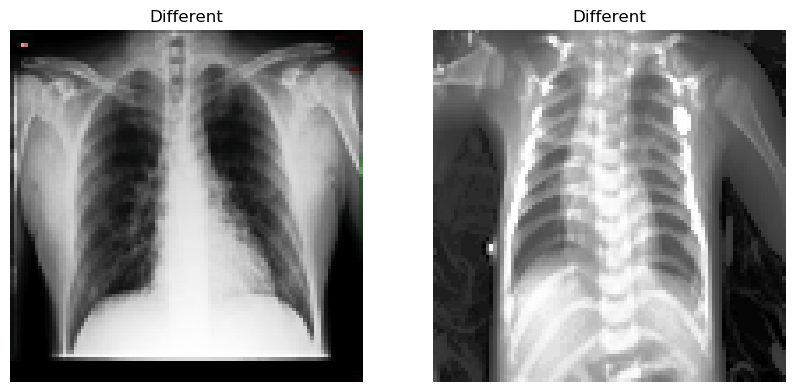

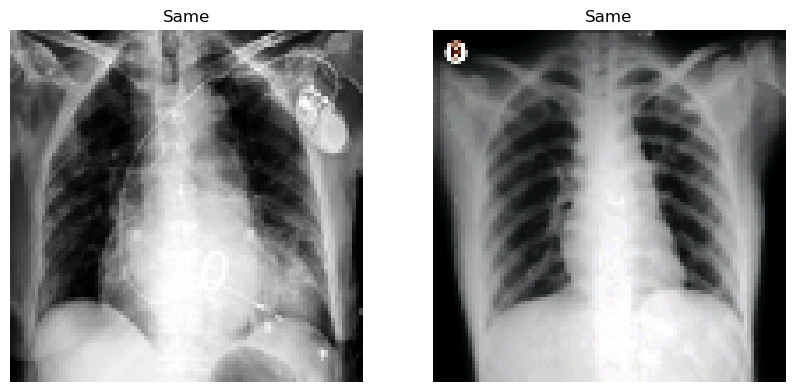

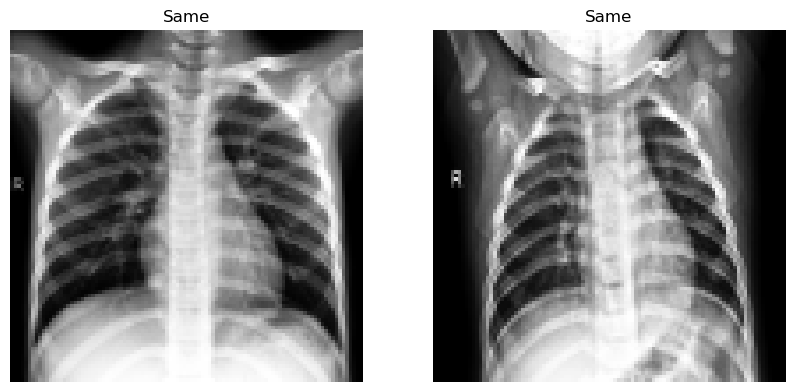

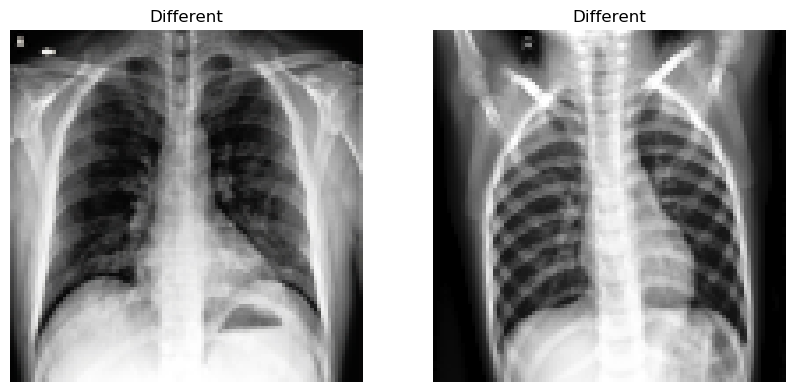

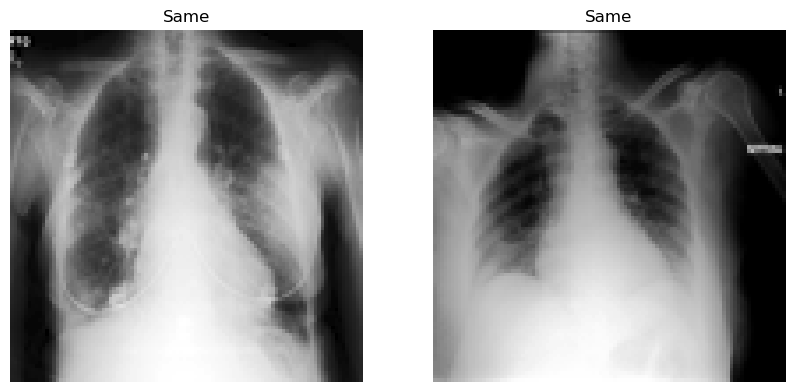

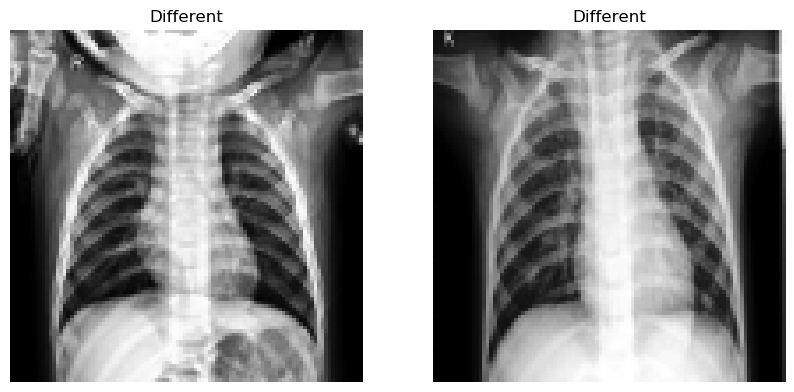

In [9]:
batch_size = 6

train_gen = Data_Generator(df, image_shape, batch_size)
batch, targets = next(train_gen.get_batch())

mLabels = ["Different", "Same"]
for n in range(batch_size):
    show_images(random.sample([batch[0][n], batch[1][n]], 2), mLabels[targets[n]])

# Create our model SiameseNet

We will reuse the weights in our previously trained VGG16 classifier as our backbone model. With this it allow us to train at fraction of the cost if train from scratch. I have test if I will from ImageNet weights it will take ~1600 epochs. But with our pretrain weights we can converage it within ~65 epochs. That is roughly about 24x faster!

In [9]:
import json
import os
from pathlib import Path

import numpy as np
import tensorflow as tf
from keras import backend as K
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.applications import ResNet50V2, VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.densenet import DenseNet121
from keras.backend.tensorflow_backend import set_session
from keras.engine.saving import model_from_json
from keras.layers import Input, Dropout, Conv2D, MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.models import Model, load_model
from keras.models import Sequential
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import plot_model

from sklearn.metrics import precision_recall_fscore_support

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [10]:
classifer_model = load_model(join("weights", "vgg16_covid19_weights.hd5"))
classifer_model.summary()

W0428 11:34:02.774445 14964 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0428 11:34:02.791413 14964 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0428 11:34:02.844654 14964 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4267: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0428 11:34:03.035204 14964 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4271: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0428 11:34:03.072534 14964 module_wrapper.py:139] From D:\Programs\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

In [12]:
# Popping last 3 layers that are added for classification
classifer_model.layers.pop()
classifer_model.layers.pop()
classifer_model.layers.pop()
classifer_model.layers.pop()
classifer_model.summary()

Model: "model_56"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 100, 100, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0  

In [13]:
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))
    
def create_Model():
    """
        Model architecture
    """
    input_shape = image_shape
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10, 10), activation='relu', input_shape=input_shape, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7, 7), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4, 4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4, 4), activation='relu', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(5120, activation='sigmoid', kernel_regularizer=l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)
    
    siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(1e-4))
    print(siamese_net.summary())
    
    # return the model
    return siamese_net

def create_vgg_model(lr=1e-4):
    """
        Model architecture
    """
    input_shape = image_shape
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()        
    pretrain_model = Model(inputs=classifer_model.input, outputs=classifer_model.layers[-1].output)
    for layer in pretrain_model.layers: # Set all layers to be trainable
        layer.trainable = True
    for layer in pretrain_model.layers[-4:]: # last 4 layer freeze
        layer.trainable = False     
    
    model.add(pretrain_model)
    model.add(Flatten())
    model.add(Dense(5120, activation='sigmoid', kernel_regularizer=l2(1e-3)))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1, activation='sigmoid')(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input], outputs=prediction)
    
    siamese_net.compile(loss="binary_crossentropy", optimizer=Adam(lr))
    print(siamese_net.summary())

    # return the model
    return siamese_net    


# class Metrics(Callback):

#     def __init__(self):
#         super().__init__()
#         self.fscores = []
#         self.threshold = 0.85

#     def on_epoch_end(self, epoch, logs=None):
#         preds = np.asarray(self.model.predict(self.validation_data[:2]))
#         preds = np.where(preds >= self.threshold, 1, 0)
#         target = self.validation_data[2]
#         precision, recall, fscore, _ = precision_recall_fscore_support(target, preds, average="micro")
#         self.fscores.append(fscore)
#         print(f"Validating model epoch: {epoch} - f1_Score: {np.round(fscore, 4)}")
#         return

In [14]:
model = create_vgg_model()
model.name = "SiameseNet_VGG16"

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 100, 100, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 5120)         104372032   input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 5120)         0           sequential_1[1][0]         

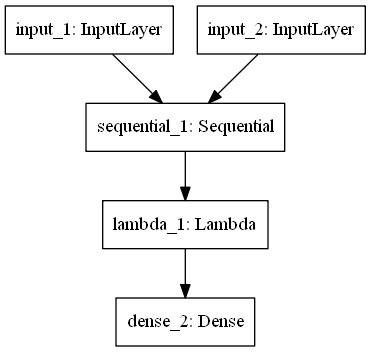

In [43]:
import keras
import pydot as pyd
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/dot.exe'

keras.utils.vis_utils.pydot = pyd

#create your model
#then call the function on your model
plot_model(model, to_file='SiameseNet_VGG16.png')

In [15]:
batch_size = 30
weights_path = join("weights", "siamese_model.hd5")

checkpointer = ModelCheckpoint(weights_path, monitor="val_loss", verbose=1, mode='min', save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=4, verbose=1, mode='min')
earlyStop = EarlyStopping(monitor="val_loss", mode='min', verbose=1, patience=8)

generator = Data_Generator(df, image_shape, batch_size).get_batch()
validator = Data_Generator(df, image_shape, batch_size).get_batch()

In [16]:
history = model.fit_generator(generator,
                              steps_per_epoch=(len(df_X_train) // batch_size) * 2,
                              validation_data=next(validator),
                              validation_steps=len(df_X_test) // batch_size,
                              epochs=800,
                              verbose=1,
                              callbacks=[checkpointer, reduceLROnPlato, earlyStop])

Epoch 1/800
2/2 [==============================] - 13s 6s/step - loss: 2.4007 - val_loss: 2.3504

Epoch 00001: val_loss improved from inf to 2.35044, saving model to weights/siamese_model.hd5
Epoch 2/800
2/2 [==============================] - 0s 240ms/step - loss: 2.3669 - val_loss: 2.3274

Epoch 00002: val_loss improved from 2.35044 to 2.32744, saving model to weights/siamese_model.hd5
Epoch 3/800
2/2 [==============================] - 0s 244ms/step - loss: 2.3283 - val_loss: 2.2893

Epoch 00003: val_loss improved from 2.32744 to 2.28931, saving model to weights/siamese_model.hd5
Epoch 4/800
2/2 [==============================] - 0s 243ms/step - loss: 2.3009 - val_loss: 2.2460

Epoch 00004: val_loss improved from 2.28931 to 2.24598, saving model to weights/siamese_model.hd5
Epoch 5/800
2/2 [==============================] - 0s 234ms/step - loss: 2.2460 - val_loss: 2.1997

Epoch 00005: val_loss improved from 2.24598 to 2.19968, saving model to weights/siamese_model.hd5
Epoch 6/800
2/2 

In [50]:
# Draw learning curve
def show_history(history):
    fig, ax = plt.subplots(1, figsize=(15,5))
    ax.set_title('loss')
    ax.plot(history.epoch, history.history["loss"], label="Train loss")
    ax.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax.legend()

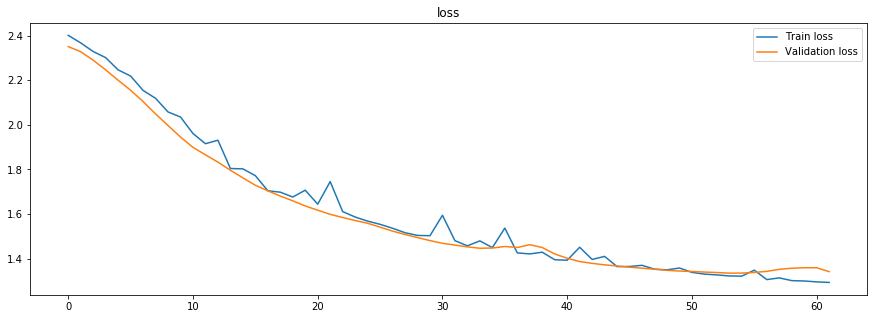

In [51]:
show_history(history)

# N-way evaluation

In [ ]:
model = load_model(join("weights", "siamese_model.hd5"))

In [19]:
class N_way_validate(object):
    
    def __init__(self, df, image_shape, n=20, k_trial=100):
        # Prepare parameters
        self.df = df.copy()
        self.h, self.w, self.c = image_shape
        self.labels = list(set(self.df['Class']))
        self.n = n
        self.k_trial = k_trial
    
    def resize_image(self, img_array):
        img = Image.fromarray(img_array)
        img = img.resize(image_shape[:-1])
        return np.array(img)

    def load_image(self, url):
        img = Image.open(url).convert('RGB')
        img = np.array(img)
        img = resize_image(img)
        img = np.divide(img, 255)
        return img

    def get_batch(self):
        
        while True:
            # Select our anchor labels
            selected_label = np.random.choice(self.labels, 1)[0]

            anchorImage_path = self.df[self.df["Class"] == selected_label].sample(n=1)['Path'].values[0]
            anchorImage = self.load_image(anchorImage_path)

            # Place holder for images
            pairs = [np.zeros((self.n, self.h, self.w, self.c)) for i in range(2)]

            # Random select the location of correct label
            targets = np.zeros((self.n,))
            targets[0] = 1
            random.shuffle(targets)

            for b in range(self.n):
                if targets[b] == 0:
                    # Negative examples
                    labels_ = self.labels.copy()
                    labels_.remove(selected_label)

                    target_label = np.random.choice(labels_, 1, replace=False)[0]
                    image2 = self.df[self.df["Class"] == target_label].sample(n=1)['Path'].values[0]
                    image2 = self.load_image(image2)
                else:
                    # positive examples
                    target_label_path = self.df[self.df["Class"] == selected_label].sample(n=1)['Path'].values[0]
                    while(target_label_path == anchorImage_path):
                        target_label_path = self.df[self.df["Class"] == selected_label].sample(n=1)['Path'].values[0]
                    image2 = self.load_image(target_label_path)

                pairs[0][b, :, :, :] = anchorImage
                pairs[1][b, :, :, :] = image2

            return pairs, targets.astype(int)
        
    def score(self, model):
        score = 0
        
        for k in tqdm(range(self.k_trial)):
            # Get batch
            batch, targets = self.get_batch()
            
            # Make prediction
            pred = model.predict(batch)
            pred = np.argmax(pred)
            actual = np.argmax(targets)
            if pred == actual:
                score += 1
                
        return np.round((score / self.k_trial) * 100, 3)

Notice that in the entire 20 pairs, there is only 1 correct pair. Model have to identify it out of the 20 pairs. We then repeat this 100 times and average the score.

Take it as a MCQ test paper with 100 questions and each question with 20 selections. It is difficult even for human.

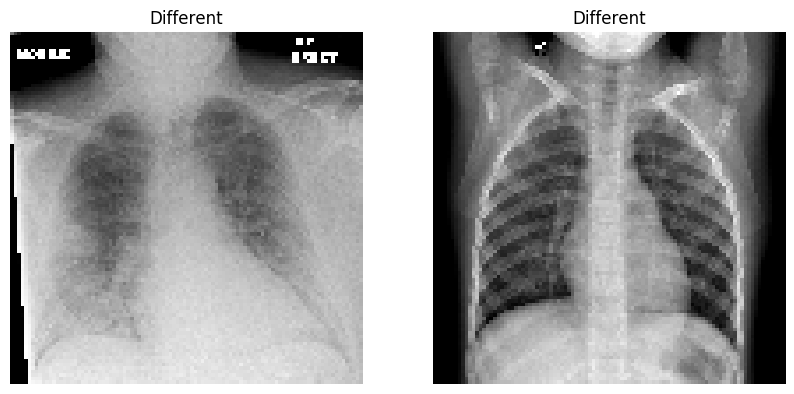

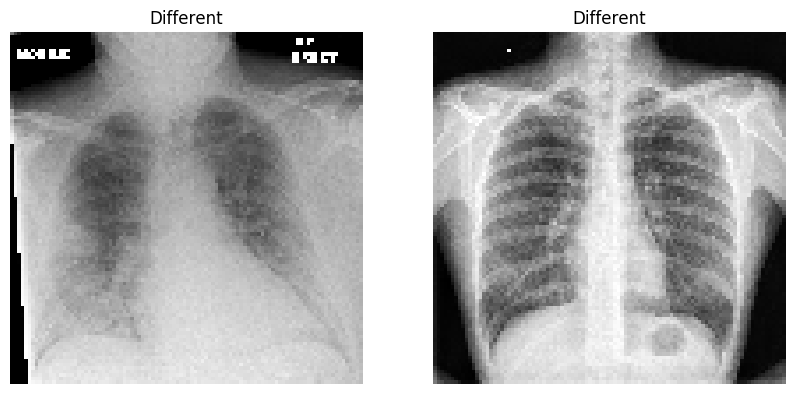

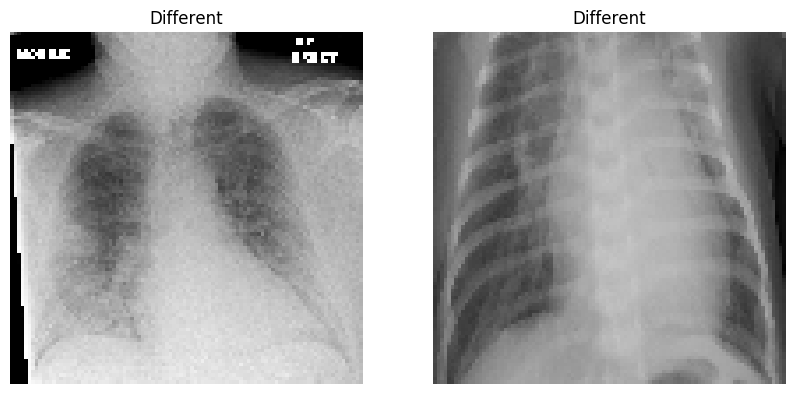

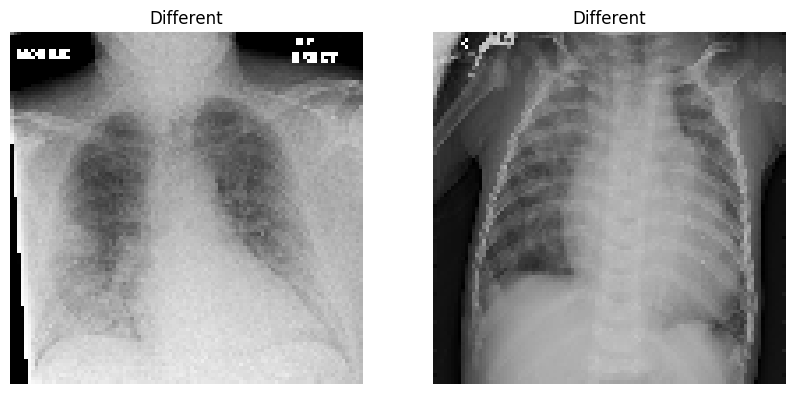

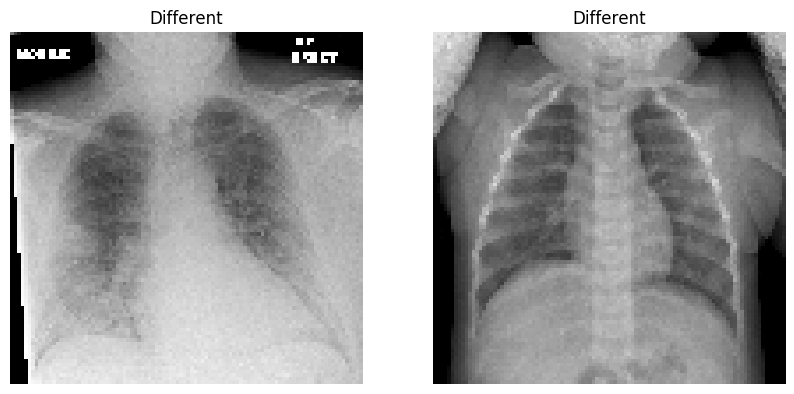

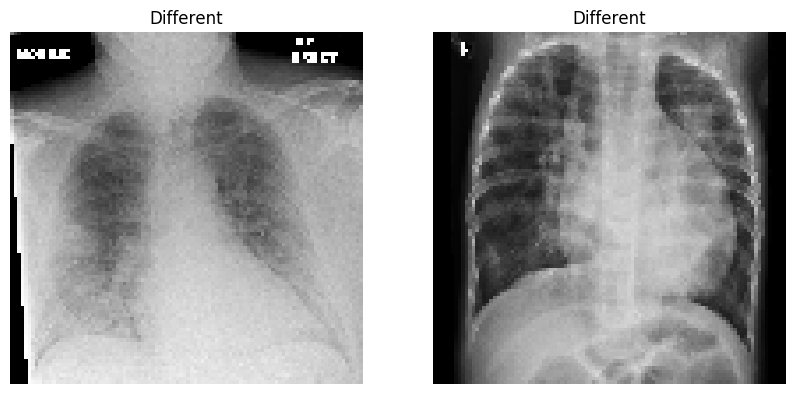

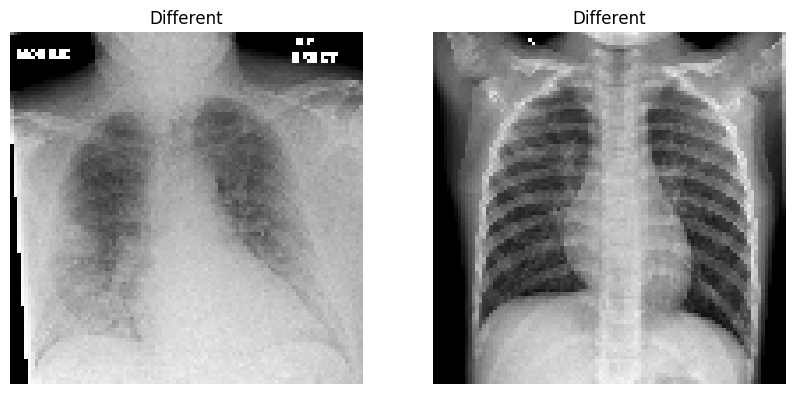

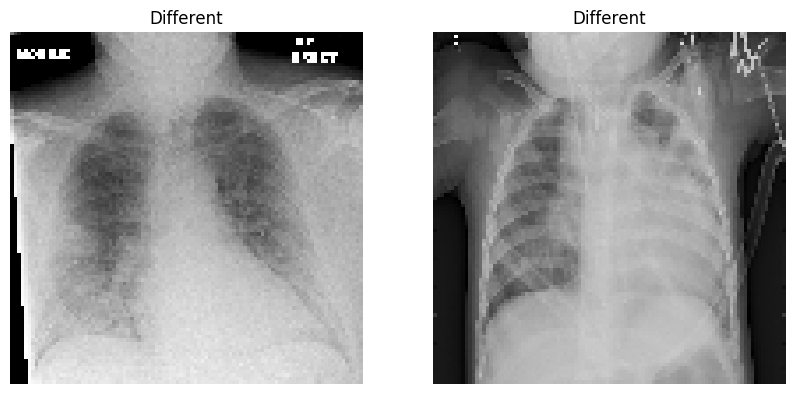

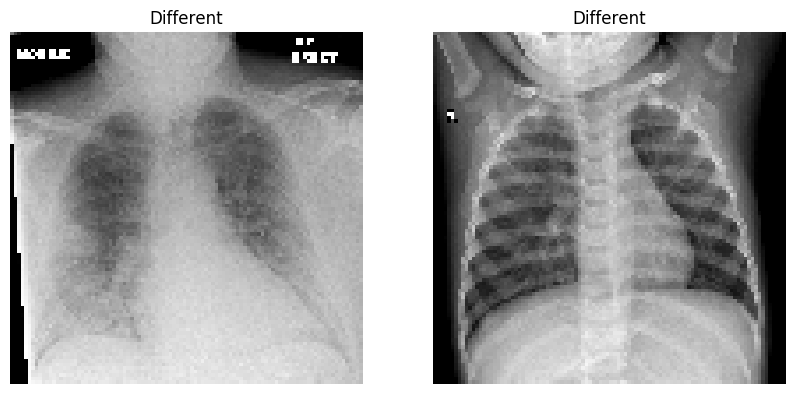

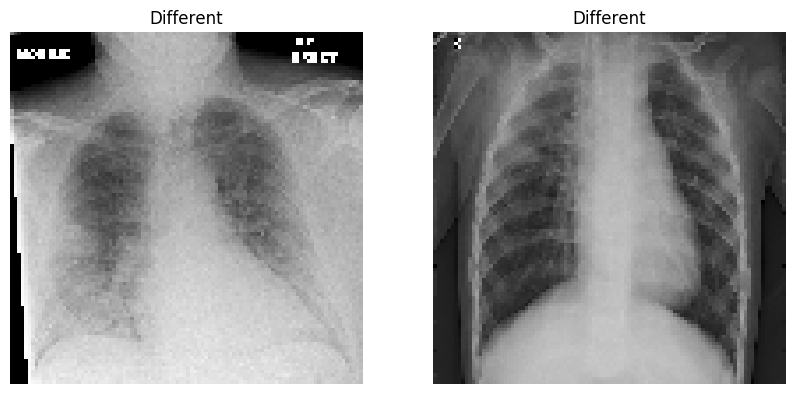

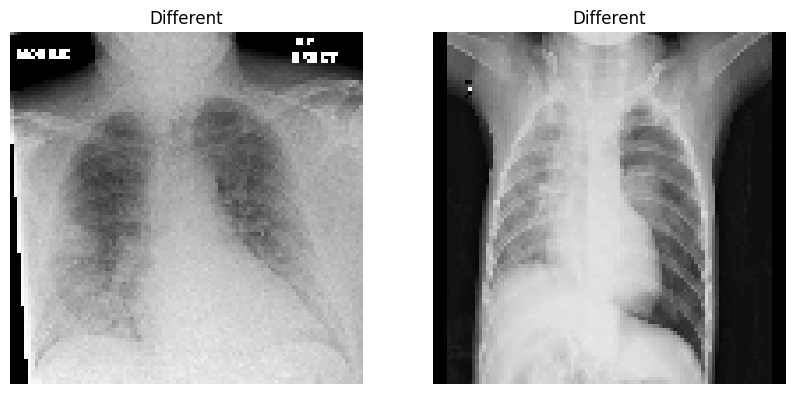

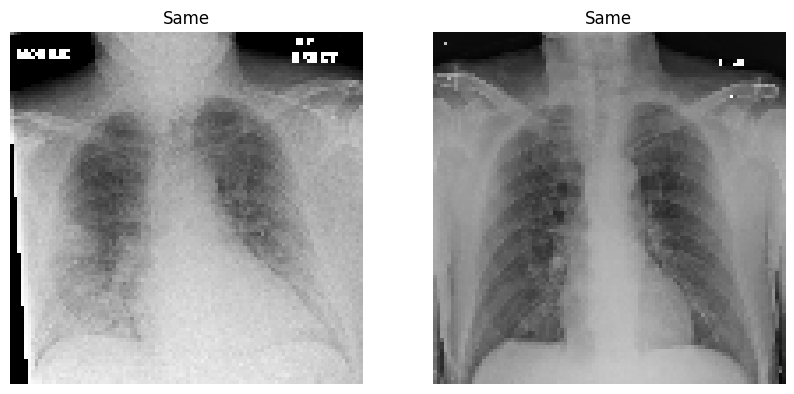

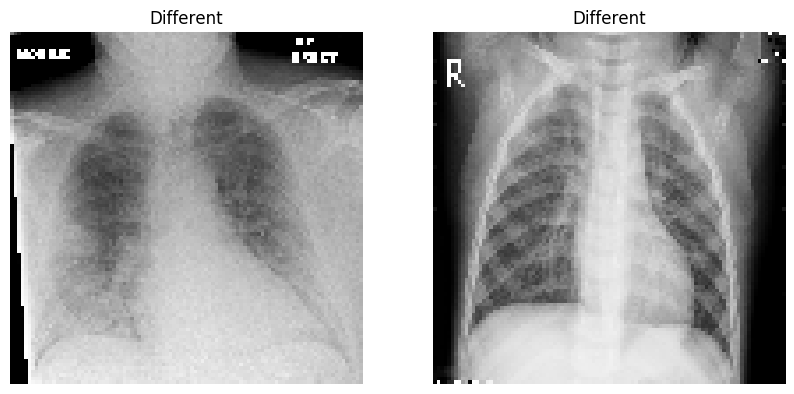

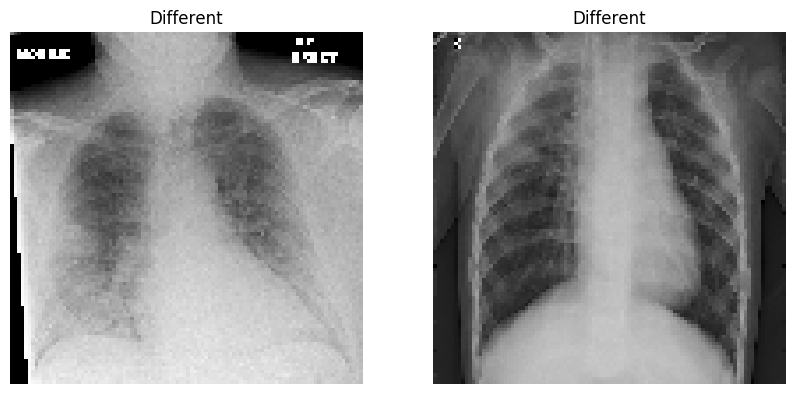

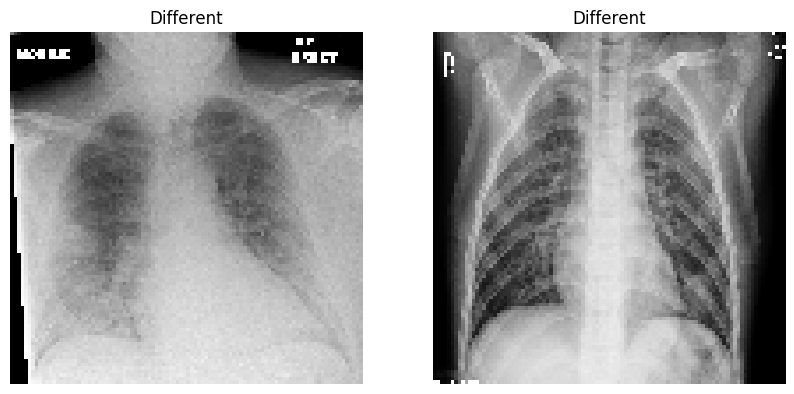

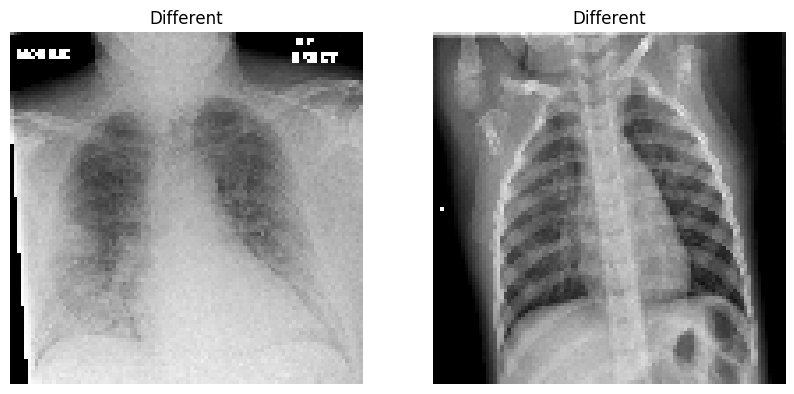

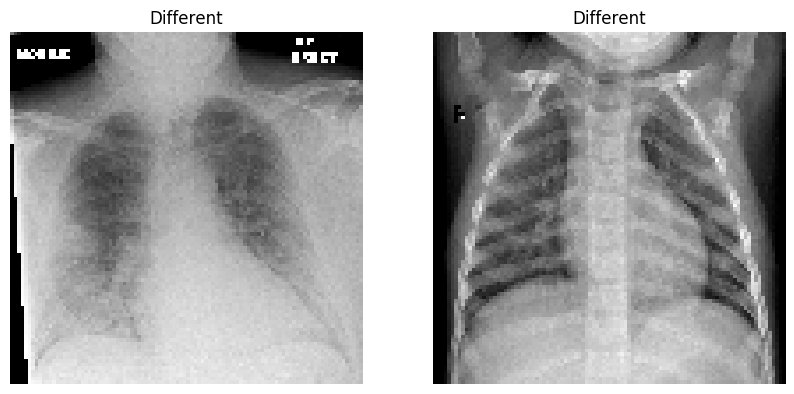

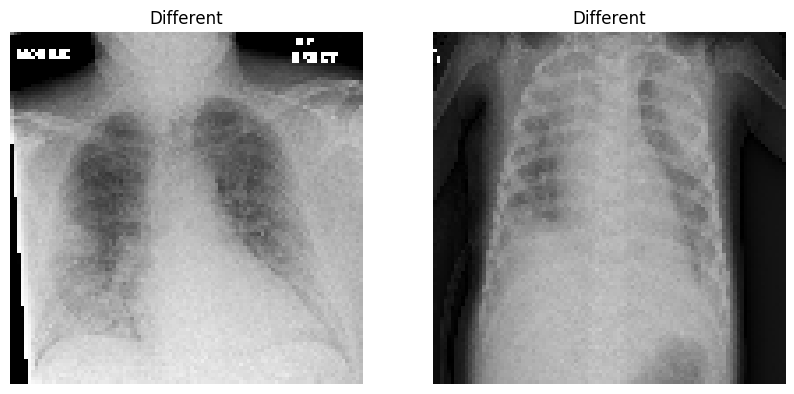

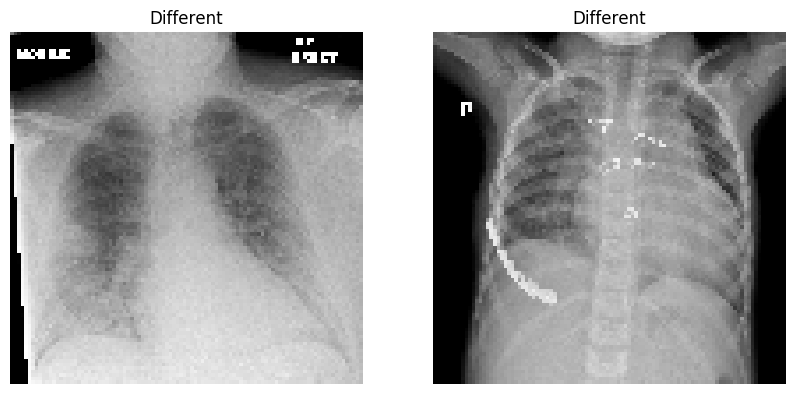

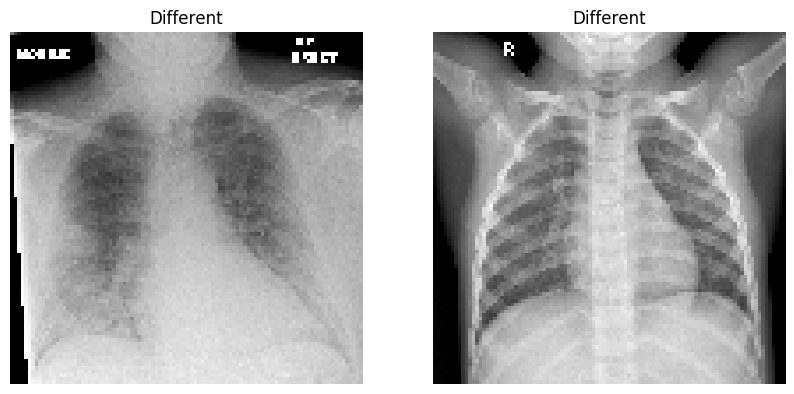

In [20]:
batch, targets = N_way_validate(df, image_shape).get_batch()

for n in range(len(targets)):
    show_images([batch[0][n], batch[1][n]], mLabels[targets[n]])

In [33]:
n_validate = N_way_validate(df_X_test, image_shape, n=20)
n_validate.score(model)

96.0

In [40]:
n_validate = N_way_validate(df_X_test, image_shape, n=30)
n_validate.score(model)

88.0

Our model is able to get 96% accuracy, with just 10 images from each class. This is awesome! But if we raise our number of selection to 30 per question, our accuracy drop to 88%.

So for any unseen images we could use this model to generate embedding.

In [52]:
!jupyter nbconvert --to HTML MultiShot_Learning.ipynb

[NbConvertApp] Converting notebook MultiShot_Learning.ipynb to HTML
[NbConvertApp] Writing 2130534 bytes to MultiShot_Learning.html
